# MONOIDS 101 FOR APACHE SPARK

<i>by Alfred J. Reich</i>

Version 2.3

This notebook describes what monoids are and the role they play in <i>reduction</i> and <i>aggregation</i> in Spark, specifically PySpark.

The following types of examples are included here, using <b>reduce</b> and <b>reduceByKey</b> to illustrate the use of the monoid concept:
* Word count
* <b>Max/Min</b> as monoids
* <b>Histogram</b> Calculation using Vectors as Monoids
* Calculating <b>Sample Means and Standard Deviations</b>
* Calculating <b>Covariances and Correlations</b> using Vectors and Matrices as Monoids
* <b>Sets</b> as monoids
* A <b>HyperLogLog</b> monoid (a <i>Sketch Method</i> for approximating set cardinality)

### Notebook Compatibility and Dependencies

Someday, hopefully, the code here will be compatible with both Python 2 and 3, but right now it has only been tested using Python 2.7

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Additional imports appear below, together with the code that requires them.

### Setup PySpark Context

For this notebook Spark is assumed to be installed in standalone mode.

Startup IPython Notebook in a terminal window with this command:

<i>IPYTHON=1 IPYTHON_OPTS="notebook --pylab inline" pyspark</i>

In [2]:
from pyspark.context import SparkContext
print('Running Spark Version {}'.format(sc.version))

from pyspark.conf import SparkConf
conf = SparkConf()
print(conf.toDebugString())

Running Spark Version 1.3.1
spark.app.name=pyspark-shell
spark.master=local[*]


## Reduction and Aggregation in Spark

Reduction and aggregration in Spark require that certain conditions be met with respect to the elements and operator being used to reduce or aggregate.

An essential condition is that, if $\oplus$ is a binary reduction/aggregation operator in Spark, and A and B are elements of type $T$, then A $\oplus$ B should also be of type $T$.

Sometimes Spark also requires that we specify an <i>identity element</i>, called "zero value" in the Spark documentation, and denoted here by $\underline{0}$.  That is, $A \oplus \underline{0} = \underline{0} \oplus A = A$.

These conditions coincide with the attributes of an algebraic structure called <i>monoid</i>.

## Monoid Definition

<i>"A monoid is an algebraic structure with a single associative binary operation and an identity element."</i> [Wikipedia](http://en.wikipedia.org/wiki/Monoid)

So, $\mathcal{M} = (S, \oplus, \underline{0})$ is a <b>monoid</b>, if...
* $S$ is a <b>non-empty set</b>
* $\oplus$ is a <b>closed, binary operator</b> on elements of $S$; that is, $a,b \in S \implies a \oplus b \in S$
* $\oplus$ is <b>associative</b>; that is, $a,b,c \in S \implies (a \oplus b) \oplus c = a \oplus (b \oplus c)$
* There is an <b>identity element</b>, $\underline{0}$, in $S$; that is, $\exists \underline{0} \in S$ such that $a \in S \implies a \oplus \underline{0} = \underline{0} \oplus a = a$.

So, a monoid is almost a <b>group</b>.  All that is lacking is the requirement that each element of $S$ also have an inverse element in $S$.  This means that all groups are also monoids.

### Some additional considerations

#### Commutative Monoids

By default, a monoid is not commutative.  That is, $a,b \in S \nRightarrow a \oplus b = b \oplus a$.

In a parallel processing environment <i>associativity</i> is needed because we do not want aggregation results to depend on the order in which elements are combined.  For the same reason, <i>commutativity</i> may also be a desirable property to have. In which case, we will want to have a <b>commutative monoid</b> (also called an <b>abelian monoid</b>).

Commutativity might <u>not</u> be desirable, however, for example, in monoids that contain time ordered elements. (For a bit more see the very brief discussion on commutativity in monoids during the Q/A session at [this workshop on functional programming](http://www.syslog.cl.cam.ac.uk/2013/09/22/liveblogging-cufp--2013/).)

<i><b><u>Rule of Thumb</u>:</b> Unless your use case specifically requires non-commutativity, try to make your monoid commutative.</i>

#### Mutability of Monoid Elements

To a mathematician, the result of $a \oplus b$ is another unique element in $S$ (unless either $a$ or $b$ is the identity element).  Neither $a$ nor $b$ changes when we sum them.

In a programming environment, however, this might be written as the expression <b>A + B</b> (where the '+' operator is overloaded) and the result returned is a modified version of <b>A</b> or <b>B</b>.  For Spark's <i>fold</i> and <i>aggregate</i> operators this is OK as long as the only value that changed is the one on the <u>left</u>, <b>A</b>.

<i><b><u>Rule of Thumb</u>:</b> Avoid mutation if possible, but if you can't (or don't want to because of efficiency) make sure that only the 'left' element in a binary expression is mutated.</i>

#### Identity Element

All monoids have an identity element, but it is not always needed in Spark:
* The RDD methods for reducing (e.g., <b>reduce</b>, <b>reduceByKey</b>) do not explicitly require the identity element
* The RDD methods for <b>folding</b>, <b>aggregating</b>, and <b>accumulating</b> do require the identity element

<i><b><u>Rule of Thumb</u>:</b> Even if you don't need to explicitly create an identity element ("zero value") for your application, take a moment to consider what it would look like if you did. If you can't visualize it, perhaps your data structure is not really a monoid.</i>

# EXAMPLES

All of the examples here use the text of [<i>"Moby Dick"</i> at Project Gutenberg](http://www.gutenberg.org/cache/epub/2701/pg2701.txt). Also, the metadata/notes at the beginning and end of Project Gutenberg's "Moby Dick" text file were removed.  The file is not included with this notebook.  If you want to "run" this notebook, you'll need to first obtain the text file for "Moby Dick" (or some other text).

## Numbers as Monoids

Let $\mathbb{R}$ and $\mathbb{Z}$ denote the real numbers and integers, respectively, then $(\mathbb{R}, +, 0)$, $(\mathbb{R}, \times, 1)$, $(\mathbb{Z}, +, 0)$, and $(\mathbb{Z}, \times, 1)$ are commutative monoids.  (All but the last one are also groups.)

### Example 1: Word Count

This is the classic use case for parallel aggregation in Spark (and Map-Reduce). It implicitly uses the monoid, $(\mathbb{Z}, +, 0)$ by first associating each word, $w$, to the number 1, in the form of a key-value pair, ($w$, 1).  Then, the pairs are aggregated by key, $w$, using the RDD operation, <i>reduceByKey</i>.  The number 1 is the monoid element, and so are the intermediate and final sums generated by <i>reduceByKey</i>.

In [3]:
import re  # Use regular expressions to do a tiny bit of "data cleaning"

book_title = "Moby Dick"
book_path = "../Data/moby_dick.txt"  # See note about Project Gutenberg above

# Remove blank lines, non-ascii chars, (some) punctuation and then split into lowercase words:
words = sc.textFile(book_path)\
          .filter(lambda line: len(line) > 0 )\
          .map(lambda line: re.sub(r'[^\x41-\x7A]+',' ', line).lower())\
          .flatMap(lambda line: line.split())

# The monoid concept is used here implicitly:
counts = words.map(lambda word: (word, 1))\
              .reduceByKey(lambda count1, count2: count1 + count2)

# Look at the result by sampling some words from the 'middle' of the counts:
counts_sample = counts.filter(lambda tup: 10 <= tup[1] <= 500).sample(False, 0.01).collect()
print(counts_sample)

[(u'invested', 21), (u'oarsman', 15), (u'happens', 12), (u'touched', 13), (u'summer', 15), (u'ah', 23), (u'appalling', 10), (u'convenient', 10), (u'night', 149), (u'help', 38), (u'jaws', 26), (u'thank', 12), (u'pay', 18), (u'several', 46)]


### Example 2: Min & Max as Monoid Operators

$(S, min, sup(S))$ and $(S, max, inf(S))$ are commutative monoids, where <i>inf</i> & <i>sup</i> are the [infimum and supremum](http://en.wikipedia.org/wiki/Infimum_and_supremum), resp.

We can find the minimum and maximum word lengths for the example, above, as follows:

In [4]:
min_max = words.map(lambda word: (len(word), len(word)))\
               .reduce(lambda pair1, pair2: (min(pair1[0], pair2[0]), 
                                             max(pair1[1], pair2[1])))
    
message = 'The minimum and maximum word lengths in "{0}" are {1} and {2}, resp.'
print(message.format(book_title, min_max[0], min_max[1]))

The minimum and maximum word lengths in "Moby Dick" are 1 and 20, resp.


Note that:
* The identity elements were not specified above.
* Also, the values do not need to be numbers.  They can be any type of quantity that can be ordered, such as <i>Datetimes</i>.

## Vector & Array Monoids

Let $\mathcal{V}$ be an n-dimensional vector or tuple over a collection of monoids, $\mathcal{M}_1, \mathcal{M}_2, ... \mathcal{M}_n$, with elementwise operator $\oplus = (\oplus_1, \oplus_2, ..., \oplus_n)$.

That is, $V(m_1, m_2, ..., m_n) \in \mathcal{V}$ where $m_i \in S_i$, $\mathcal{M_i} = (S_i, \oplus_i, \underline{0}_i)$, and i = 1, ..., n.

### Example 3: Histogram Calculation

This example uses vectors of integers.  In the notation above, $\mathcal{M}_i = (\mathbb{Z}, +, 0)$ for $i = 1, ..., n$.

The [NumPy histogram operator](http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) takes a set of data and a binning specification and returns multiple values, the first of which is a 1-dimensional array (vector) representing the histogram.

If we <b>only input <u>one</u> value</b>, then an array of zeros with a single 1 somewhere in it will be returned. This is illustrated in the cell, below:

In [5]:
import numpy as np
bins = range(1, min_max[1] + 2)  # min_max[1] is the maximum word length calculated above
example_one_word_histogram = np.histogram(len('whale'), bins)[0]
print('Word length histogram for the single word, "whale": {}'.format(example_one_word_histogram))

Word length histogram for the single word, "whale": [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Now, if we do what was done above for each of the words in the RDD, <i>words</i>, computed earlier, and then sum up (reduce) the arrays returned, we will obtain a histogram of word lenths:

In [6]:
hist = words.map(lambda word: np.histogram(len(word), bins)[0])\
            .reduce(lambda hist1, hist2: hist1 + hist2)

Here's a plot of the result:

<Container object of 20 artists>

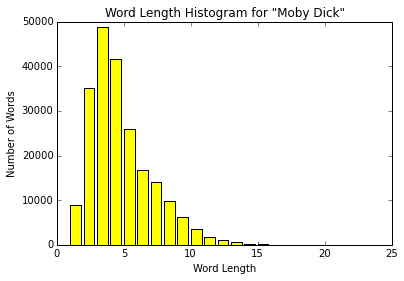

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Word Length Histogram for "' + book_title + '"')
ax1.set_xlabel('Word Length')
ax1.set_ylabel('Number of Words')
ax1.bar(bins[:-1], hist, color='Yellow')

## Statistical Calculations

Some basic statistics can be obtained by simply maintaining a running sum of values (via reduce/aggregate), such as counts ($\sum 1$ = N = sample size), sums of observations ($\sum x_i$), sums of squares of observations ($\sum x_i^2$), or sums of crossproducts ($\sum x_iy_i$).  These sums can be used to compute means, variances, standard deviations, covariances, and correlations of numerical quantities.  This is illustrated in the next two examples.

### Example 4: Calculating Sample Means and Standard Deviations

First, define two functions that will be passed to the PySpark RDD operators, <i>reduceByKey</i> and <i>mapValues</i>.

In [8]:
from math import sqrt

def reduce_values(val1, val2):
    '''Reduce two triples to a single triple.'''
    (n1, sum1, sumsqr1) = val1
    (n2, sum2, sumsqr2) = val2
    return (n1 + n2, sum1 + sum2, sumsqr1 + sumsqr2)

def calc_mean_stddev(tup):
    '''Take a triple of sums and return a triple of statistics.'''
    (n, sum_, sumsqr) = tup  # triple of sums
    if n == 0:
        mean = 0.0
        stddev = 0.0
    elif n == 1:
        mean = sum_
        stddev = 0.0
    else:
        mean = float(sum_) / n
        samplevar = (float(sumsqr) - (n * mean * mean)) / (n - 1)
        if samplevar < 0.0:  # Theoretically impossible, but possible w/ floating point
            stddev = 0.0
        else:
            stddev = sqrt(samplevar)
    return (n, mean, stddev)  # triple of statistics

Now, for each word, $w_i$, in the text, if we let $w^0_i$ be the first letter of the word and and $|w_i|$ be the length of the word, then the PySpark operations in the <i>map</i> operation below will form the key-value pair, ($w^0_i$, (1, $|w_i|$, $|w_i|^2$)) -- Note that the <i>value</i> part of the key-value pair is a triple.

Then, when <i>reduce_values</i>, defined above, is passed to <i>reduceByKey</i> it will compute ($w^0_i$, (N, $\sum|w_i|$, $\sum|w_i|^2$)), where N is the number of words that start with the letter $w^0_i$.

Finally, <i>calc_mean_stddev</i> is passed to <i>mapValues</i> in order to turn the value part of each tuple, (N, $\sum|w_i|$, $\sum|w_i|^2$), into (N, $\overline{w}$, $\sqrt{Var(w)}$), where $\overline{w}$ is the average length of words that start with letter $w^0_i$, and $Var(w)$ is the variance of the word lengths for the particular starting letter.

All of this happens in the next cell:

In [9]:
stats = words.map(lambda word: (word[0], (1, len(word), len(word) * len(word))))\
             .reduceByKey(reduce_values)\
             .mapValues(calc_mean_stddev)\
             .collectAsMap()

And, here is the result:

In [10]:
print('Word Count (N) and Word Length Statistics (Mean & Standard Deviation) by Starting Letter:')
print('     N     Mean   SDev')
for letter in 'abcdefghijklmnopqrstuvwxyz':
    count, mean, stddev = stats[letter]
    print('{} {:>6} {:6.2f} {:6.2f}'.format(letter, count, mean, stddev))

Word Count (N) and Word Length Statistics (Mean & Standard Deviation) by Starting Letter:
     N     Mean   SDev
a  23501   3.26   2.15
b  11164   4.43   2.00
c   8371   6.73   2.35
d   5819   5.50   2.51
e   3918   6.17   2.45
f   8267   4.86   1.84
g   3505   5.30   1.93
h  13730   4.02   1.87
i  14428   3.06   2.66
j    839   5.00   1.77
k    951   4.91   1.38
l   6083   4.99   1.70
m   8391   4.72   2.20
n   4793   4.21   2.22
o  13948   2.95   1.72
p   6043   6.67   2.23
q    716   7.01   1.48
r   3865   6.27   2.07
s  19876   5.06   2.39
t  35261   3.71   1.50
u   2634   5.55   3.43
v   1575   5.85   1.98
w  14467   4.55   1.44
x      5   4.20   2.17
y   2498   3.36   1.26
z     34   5.79   1.79


### Example 5: Calculating Covariances and Correlations

The previous example used key-value pairs of the form, ($k_i$, (1, $x_i$, $x_i^2$)), where $k_i$ is a key and $x_i$ is a scalar observation, to compute means and variances by key.  If the observations are vectors instead of scalars the same thing can still be done using vector and matrix math.

So, assume the observations are sampled from an m-dimensional random variable, $\underline{\mathbf{X}}$, so that they consist of m-dimensional column vectors, $\underline{\mathbf{x}}_i^T = (x_{i,1}, x_{i,2}, ..., x_{i,m})$, where $i=1,...N$.  For each key the elementwise sum of the value portion of key-value pairs of the form, ($k_i$, (1, $\underline{\mathbf{x}}_i$, $\underline{\mathbf{x}}_i\underline{\mathbf{x}}_i^T$)), will result in ($k_i$, ($N$, $\sum_{i}\underline{\mathbf{x}}_i$, $\sum_{i}\underline{\mathbf{x}}_i\underline{\mathbf{x}}_i^T$)).  From this we can compute the m-dimensional sample mean vector, $\underline{\overline{\mathbf{x}}}_i$, and the $m \times m$ sample covariance matrix, $cov(\underline{\mathbf{X}}) = \underline{\Sigma}_i = [\sigma_{i,j}]_{i,j=1,..N}$ using the following two formulas:

$\underline{\overline{\mathbf{x}}}_i = (\sum_{i}\underline{\mathbf{x}}_i)/N$

$\underline{\Sigma}_i = (\sum_{i}\underline{\mathbf{x}}_i\underline{\mathbf{x}}_i^T - N \underline{\overline{\mathbf{x}}}_i \underline{\overline{\mathbf{x}}}_i^T)/(N-1)$

The correlation matrix can also be computed now.  Denote the elements on the diagonal of $\underline{\Sigma}_i$ as squares, $\sigma_{i,i} = \sigma_i^2$ for $i = 1,...,m$, then $\sigma_i$ is the standard deviation of the $i^{th}$ component of $\underline{\mathbf{X}}$.  Then if we construct a diagonal matrix, $D$, with the reciprocals of the standard deviations, $1/\sigma_i$, along the diagonal, the correlation matrix, $corr(\underline{\mathbf{X}})$, can be computed as $D\underline{\Sigma}_i D$.

To illustrate covariance and correlation calculations, we will look at bivariate data, $W_i = (x_i, y_i), i=1,...n$, where $n$ is the total number of words in the text, $x_i$ is the number of letters in a word (word length), and $y_i$ is the number of <u>unique</u> letters in the same word.

<i>(NOTE: There are many more words in our sample text than there are unique words, by an order of magnitude, so from an NLP perspective it might be more appropriate to just work with unique words, but the focus here is on how to do specific calculations, so we're just going to use all the words.)</i>

Either way, intuition says that the two quantities, $x_i$ and $y_i$, should be linearly correlated.  We'll first try to visually confirm this intuition.

#### Visualize the Bivariate Data

We'll take the following <b>steps</b> to construct and visualize the bivariate data:

1. First, create the bivariate <i>points</i>, $(x_i, y_i), i=1,...n$.

1. $n$ is relatively large but the points all have integer coordinates ranging from 1 to the maximum word length.  So, the number of unique points should be quite small.  They will be collected into a dictionary where the unique points are the keys and the values are the numbers of words (counts) that correspond to the keys.

2. Plot the unique points from the dictionary constructed in Step 2 using circles that are sized according to the logarithm of the number of words represented by each point.

In [11]:
# Step 1:

points = words.map(lambda word: (len(word), len(set(word)))).collect()

print('There are {0} "points" (equal to the number of words in the text), but only {1} are unique.'\
      .format(len(points), len(set(points))))

There are 214688 "points" (equal to the number of words in the text), but only 90 are unique.


In [12]:
# Step 2:

from collections import Counter
from math import log

# key=point, value=count; e.g., count[(6,5)] ==> 6603
counts = Counter(points)

# Here's an example:
sample_point = (6,5)
print("For example, there are {0} words of length {1} with {2} unique letters."\
      .format(counts[sample_point], sample_point[0], sample_point[1]))

For example, there are 6603 words of length 6 with 5 unique letters.


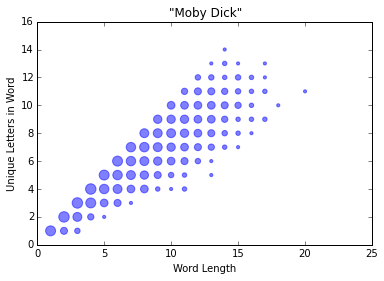

In [13]:
def transform(x):  # A made-up transform to make the scatter plot look OK
    return (int(log(x)) + 1) * 10

xs = []; ys = []; log_count = []  # Some lists to store x, y, and (transformed) count values
for point, count in counts.iteritems():
    xs.append(point[0])
    ys.append(point[1])
    log_count.append(transform(count))  # Determines the size of a dot in the scatter plot

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title('"' + book_title + '"')
ax2.set_xlabel('Word Length')
ax2.set_ylabel('Unique Letters in Word')
plt.scatter(xs, ys, s=log_count, color='Blue', alpha=0.5)

Clearly, the plot shows a linear relationship between word length and unique letters in words.

We can quantify the correlation by first calculating the <b>Covariance Matrix</b> and <b>Correlation</b>.

In [14]:
def make_value_tuple(word):
    num_letters = float(len(word))
    num_unique_letters = float(len(set(word)))
    #num_letter = word.count('e')
    x = np.array([[num_letters], [num_unique_letters]])  # column vector
    xxT = x * x.transpose()  # matrix
    return (1, x, xxT)

def calc_covariance(tup):
    (n, sum_, sumsqr) = tup
    dim = sum_.shape[0]
    zero_vec = np.zeros((dim,1))
    zero_mat = np.zeros((dim,dim))
    if n == 0:
        mean = zero_vec
        stddev = zero_mat
    elif n == 1:
        mean = sum_
        stddev = zero_mat
    else:
        mean = sum_ / n
        cov = (sumsqr - (n * mean * mean.transpose())) / (n - 1)
        inv_diag_mat = np.diag(1.0/np.sqrt(cov.diagonal()))  # diag of cov, sqrt'ed & inverted
        corr = inv_diag_mat.dot(cov).dot(inv_diag_mat)
    return (n, mean, cov, corr)

In [15]:
stats2 = words.map(lambda word: (word[0], make_value_tuple(word)))\
              .reduceByKey(reduce_values)\
              .mapValues(calc_covariance)\
              .collectAsMap()

In [16]:
print('   Count  Mean1 Mean2  Sig11 Sig22 Cov12   Corr')
for letter in 'abcdefghijklmnopqrstuvwxyz':
    count, mean, cov, corr = stats2[letter]
    print('{} {:>6} {:6.2f} {:5.2f} {:6.2f} {:5.2f} {:5.2f} {:6.2f}'\
          .format(letter, count, mean[0][0], mean[1][0],
                  sqrt(cov[0][0]), sqrt(cov[1][1]), cov[0][1], corr[0][1])
         )

   Count  Mean1 Mean2  Sig11 Sig22 Cov12   Corr
a  23501   3.26  2.98   2.15  1.76  3.65   0.97
b  11164   4.43  4.07   2.00  1.66  3.16   0.95
c   8371   6.73  5.89   2.35  1.71  3.66   0.91
d   5819   5.50  4.77   2.51  1.94  4.52   0.93
e   3918   6.17  5.09   2.45  1.99  4.56   0.94
f   8267   4.86  4.55   1.84  1.53  2.67   0.95
g   3505   5.30  4.73   1.93  1.50  2.65   0.91
h  13730   4.02  3.78   1.87  1.52  2.74   0.96
i  14428   3.06  2.77   2.66  1.99  5.16   0.97
j    839   5.00  4.69   1.77  1.47  2.44   0.94
k    951   4.91  4.34   1.38  1.13  1.38   0.88
l   6083   4.99  4.53   1.70  1.39  2.15   0.91
m   8391   4.72  4.36   2.20  1.75  3.66   0.95
n   4793   4.21  3.84   2.22  1.60  3.39   0.96
o  13948   2.95  2.84   1.72  1.44  2.42   0.98
p   6043   6.67  5.84   2.23  1.75  3.53   0.90
q    716   7.01  5.25   1.48  1.47  0.68   0.31
r   3865   6.27  5.37   2.07  1.48  2.64   0.86
s  19876   5.06  4.50   2.39  1.97  4.45   0.94
t  35261   3.71  3.45   1.50  1.21  1.70

So, in "Moby Dick", and with the exception of words that begin with the letter "q", the number of letters in word has a relatively high positive correlation (> 0.80) with the number of <u>unique</u> letters in the word.

In [17]:
stats3 = calc_covariance(words.map(lambda word: make_value_tuple(word))\
                              .reduce(reduce_values))
stats3

(214688, array([[ 4.3588603 ],
        [ 3.96289965]]), array([[ 5.29021937,  4.04926857],
        [ 4.04926857,  3.40028738]]), array([[ 1.        ,  0.95473299],
        [ 0.95473299,  1.        ]]))

## Set Monoids

The set of all subsets of a set, $S$, is called its <i>power set</i> and is denoted by $\mathcal{P}(S)$.

<p>$(\mathcal{P}(S), \cup, \emptyset)$ is a commutative monoid, where $\cup$ is the <i>union operator</i> and $\emptyset$ is the <i>empty set</i>.</p>

### Example 6: Unique Words by Starting Letter

Here, for each word we create a key-value pair consisting of the first letter of the word as the key, and the (singleton) set containing only that word as the value; for example, <i>("w", {"whale"})</i>.  Then we <i>reduceByKey</i>, using set union as the operator.

In [18]:
words_by_first_letter = words.map(lambda word: (word[0], {word}))\
                             .reduceByKey(lambda wordset1, wordset2: wordset1 | wordset2)

Collapse the RDD into a single Python dictionary and look at an example entry:

In [19]:
wordmap = words_by_first_letter.collectAsMap()
letter = 'b'
wordset = wordmap[letter]

# First few words that begin with the letter
print('There are {} unique words that begin with the letter "{}".'.format(len(wordset), letter))
n = 6
print('Here are the first {0}: {1}'.format(n, sorted(list(wordset))[:n]))

There are 1008 unique words that begin with the letter "b".
Here are the first 6: [u'babbling', u'babe', u'babel', u'babes', u'babies', u'baboon']


### Example 7: Set Cardinality using HyperLogLog in Monoid Form

If all we need is an approximate count of the unique elements in a set, then we can approximate it using the HyperLogLog (HLL) algorithm.  Fortunately, the HLL can be, and has been, implemented as a monoid.

NOTE: The HLL implementation used here comes from the file "hll.py" in the GitHub repository, [Parsely/python-pds](https://github.com/Parsely/python-pds), but it has been modified to remove the dependency on the <i>smhasher</i> module so that it can be run using the [Anaconda Python distribution](https://store.continuum.io/cshop/anaconda/) provided by [Continuum Analytics](http://continuum.io/).  The modified file can be obtained from the GitHub gist, [hllx.py](https://gist.github.com/dc6a045704cfdd76bb4c.git), and is imported as a module below.  (To find the modifications, look in "hllx.py" for inline comments that begin with '# !!! '.)  The monoid $\oplus$ operator is implemented in the HyperLogLog object as the <i>\_\_or\_\_</i> method, so the Python union operator, "|", can be used to "sum" the HLLs.

Below, we follow the same approach as that used in Example 6.  A helper function, <i>make_HLL</i>, is used to simplify the process of creating key-value pairs where an HLL "containing" a single item is used as the value in the pair, rather than a singleton set.

In [20]:
from hllx import HyperLogLog  # See note above

def make_HLL(err_rate):
    def fnc(word):
        HLL = HyperLogLog(err_rate)
        HLL.add(word)
        return (word[0], HLL)
    return fnc

HLL_error_rate = 0.01
words_by_first_letter_HLL = words.map(make_HLL(HLL_error_rate))\
                                 .reduceByKey(lambda HLL1, HLL2: HLL1 | HLL2)

wordmap_HLL = words_by_first_letter_HLL.collectAsMap()
wordset_HLL = wordmap_HLL[letter]

print('An HLL is a set-like object: {}'.format(wordset_HLL))
print('There are approximately {} words that begin with the letter "{}".'.format(len(wordset_HLL), letter))

An HLL is a set-like object: <hllx.HyperLogLog object at 0x10c507ed0>
There are approximately 1003 words that begin with the letter "b".


### To Be Done

* Add links and references